In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content
!rm -rf 2dFluidSim
!git clone https://github.com/benjaminkeating00-gif/2dFluidSim.git
%cd /content/2dFluidSim


/content
Cloning into '2dFluidSim'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 35 (delta 15), reused 35 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 17.16 KiB | 17.16 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/2dFluidSim


In [3]:
!pip -q install phiflow
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


inflow_A_mass_per_step: 9.6
inflow_B_mass_per_step: 9.6


/usr/local/lib/python3.12/dist-packages/phiml/backend/torch/_torch_backend.py:873: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


Initial loss: -0.007682276
Sanity forward loss (no grad): -0.007682276
After 1 step, loss: -0.12515558

--- Mass tracking every 10 timesteps ---
t 4 inflow_t 1.0
   addedA 9.600000381469727 addedB 9.600000381469727
t 5 inflow_t 0.0
   addedA 0.0 addedB 0.0
t 6 inflow_t 0.0
   addedA 0.0 addedB 0.0
t=8: aL_t=0.0, aR_t=0.0, vel_comp_max=2.064003, mass_A=52.81833, mass_B=52.818336
t=9: aL_t=0.0, aR_t=0.0, vel_comp_max=2.1804326, mass_A=53.28769, mass_B=53.287697
Timestep 10: mass_A = 53.28769, mass_B = 53.287697, total = 106.575386
ASSERT t=10: uL.time[t]=-0.0008710399, tanh(uL.time[t])=-0.0008710397, aL_t=-0.8710397
t 10 inflow_t 0.0
   addedA 0.0 addedB 0.0
t=10: aL_t=-0.8710397, aR_t=-0.8597497, vel_comp_max=2.2790074, mass_A=53.79857, mass_B=53.79858
t=11: aL_t=-0.32781956, aR_t=-0.24653503, vel_comp_max=2.3499713, mass_A=54.166336, mass_B=54.16633
t=12: aL_t=0.07156883, aR_t=0.19361544, vel_comp_max=2.4099073, mass_A=54.572292, mass_B=54.571705
t=13: aL_t=0.343398, aR_t=0.49322146, v

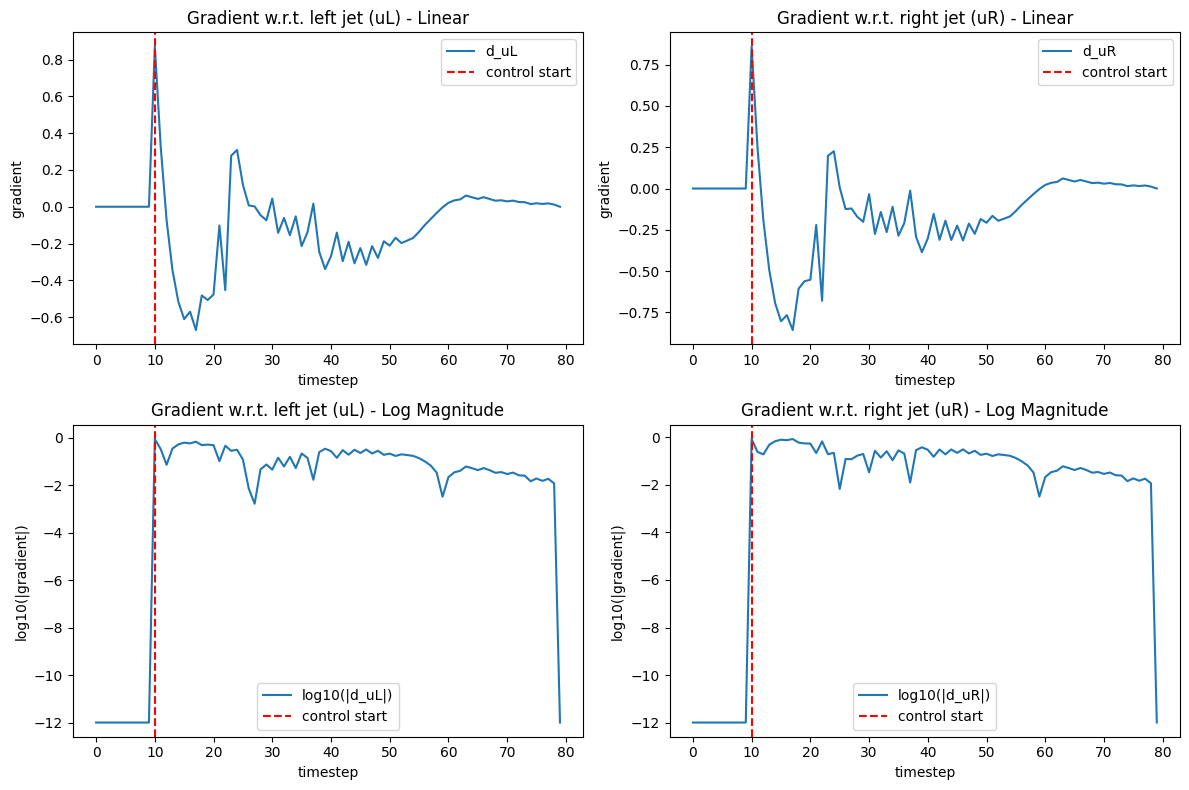

In [4]:
# -*- coding: utf-8 -*-
"""Φ-Flow fluid sim (script version).

Runs a 2D smoke simulation with a bottom-center box inflow,
then computes a simple gradient objective toward a fixed target plume.
"""
import matplotlib
from phi.torch.flow import *
import matplotlib.pyplot as plt

plt.close("all")

# Build two inflow sources: left-middle and right-middle of the domain.
def make_inflow_A():
  return 0.6 * CenteredGrid(
    Box(vec(x=6, y=0), vec(x=10, y=4)),
    extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
  )

def make_inflow_B():
  return 0.6 * CenteredGrid(
    Box(vec(x=22, y=0), vec(x=26, y=4)),
    extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
  )


INFLOW_A = make_inflow_A()
INFLOW_B = make_inflow_B()

# Region masks: right half for dye_A, left half for dye_B.
REGION_A = CenteredGrid(
  Box(vec(x=16, y=0), vec(x=32, y=40)),
  extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)
REGION_B = CenteredGrid(
  Box(vec(x=0, y=0), vec(x=16, y=40)),
  extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)

# Define two jet masks as thin rectangles near left/right walls at mid-height.
JET_L = CenteredGrid(
  Box(vec(x=1, y=16), vec(x=3, y=26)),
  extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)
JET_R = CenteredGrid(
  Box(vec(x=29, y=16), vec(x=31, y=26)),
  extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)

# Jet action tensors: differentiable time-series controls.
# Left jet blows +x (right), right jet blows -x (left).
NUM_STEPS = 80
CONTROL_START = 10  # timestep when jet control kicks in

# Precomputed control mask: 0 before CONTROL_START, 1 after
# IMPORTANT: Recreate this whenever you change CONTROL_START!
control_mask = math.tensor(
    [0.0 if t < CONTROL_START else 1.0 for t in range(NUM_STEPS)],
    batch('time')
)

# Inflow fill phase: inflow active for t < FILL_END, then stops
# IMPORTANT: Recreate this whenever you change FILL_END!
FILL_END = 5  # timestep when inflow stops
inflow_mask = math.tensor(
    [1.0 if t < FILL_END else 0.0 for t in range(NUM_STEPS)],
    batch('time')
)

# Unconstrained parameters for optimization (will be mapped through tanh)
uL = math.zeros(batch(time=NUM_STEPS))
uR = math.zeros(batch(time=NUM_STEPS))

# Maximum jet strength (bounded via tanh)
A_MAX = 1000.0   # keep small for gradient stability; raise to 2, 3, 5 once stable

# Diagnostic: check inflow masses for discretization differences.
print("inflow_A_mass_per_step:", math.sum(INFLOW_A.values))
print("inflow_B_mass_per_step:", math.sum(INFLOW_B.values))

# Perform one physics timestep including advection, buoyancy, and projection.
def step(dye_A: CenteredGrid, dye_B: CenteredGrid, velocity: StaggeredGrid, aL_t: float, aR_t: float, inflow_scale=1.0):
  dye_A = advect.semi_lagrangian(dye_A, velocity, dt=1) + inflow_scale * INFLOW_A
  dye_B = advect.semi_lagrangian(dye_B, velocity, dt=1) + inflow_scale * INFLOW_B
  total = dye_A + dye_B
  buoyancy_force = (total * vec(x=0, y=0.5)) @ velocity
  jet_force_centered = (aL_t * JET_L - aR_t * JET_R) * vec(x=1, y=0)
  velocity = velocity + (buoyancy_force + jet_force_centered @ velocity)
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1)
  velocity, _ = fluid.make_incompressible(velocity, (), Solve(rel_tol=1e-3, abs_tol=1e-3, max_iterations=1000, rank_deficiency=0))


  return dye_A, dye_B, velocity

# Roll out a trajectory and stack dye frames over time for visualization.
def rollout(dye_A0: CenteredGrid, dye_B0: CenteredGrid, vel0: StaggeredGrid, actions_L, actions_R, print_mass=False, debug=False):
  steps = actions_L.shape.get_size('time')
  frames_A = [dye_A0]
  frames_B = [dye_B0]
  dye_A, dye_B, vel = dye_A0, dye_B0, vel0
  for t in range(steps):
    # Use precomputed mask: 0 before CONTROL_START, 1 after
    mask_t = control_mask.time[t]
    aL_t = mask_t * A_MAX * math.tanh(actions_L.time[t])
    aR_t = mask_t * A_MAX * math.tanh(actions_R.time[t])

    if debug and t == CONTROL_START:
      print(f"ASSERT t={t}: uL.time[t]={actions_L.time[t]}, tanh(uL.time[t])={math.tanh(actions_L.time[t])}, aL_t={aL_t}")

    # Get inflow scale for this timestep (1.0 before FILL_END, 0.0 after)
    inflow_t = inflow_mask.time[t]

    # Debug: verify inflow mask is actually being applied
    if debug and t in [FILL_END-1, FILL_END, FILL_END+1, FILL_END+5]:
      print("t", t, "inflow_t", float(inflow_t.native()))
      addA = math.sum((inflow_t * INFLOW_A).values)
      addB = math.sum((inflow_t * INFLOW_B).values)
      print("   addedA", float(addA.native()), "addedB", float(addB.native()))

    # MacCormack instrumentation: compare predictor vs corrector (disabled)
    # if debug:
    #   pred_A = advect.semi_lagrangian(dye_A, vel, dt=1)
    #   pred_B = advect.semi_lagrangian(dye_B, vel, dt=1)
    #   corr_A = advect.mac_cormack(dye_A, vel, dt=1)
    #   corr_B = advect.mac_cormack(dye_B, vel, dt=1)
    #   delta_A = corr_A - pred_A
    #   delta_B = corr_B - pred_B
    #   sum_delta_A = float(math.sum(delta_A.values).native())
    #   sum_delta_B = float(math.sum(delta_B.values).native())
    #   mean_delta_A = float(math.mean(delta_A.values).native())
    #   mean_delta_B = float(math.mean(delta_B.values).native())
    #   print(f"t={t}: MacCormack correction bias: "
    #         f"sum(delta_A)={sum_delta_A:+.6f}, sum(delta_B)={sum_delta_B:+.6f}, "
    #         f"mean(delta_A)={mean_delta_A:+.8f}, mean(delta_B)={mean_delta_B:+.8f}")

    dye_A, dye_B, vel = step(dye_A, dye_B, vel, aL_t, aR_t, inflow_scale=inflow_t)

    # Detect NaNs early (only in debug mode to avoid tensor->float during grad)
    if debug:
      vmax = math.max(math.abs(vel.values))
      vmax_f = float(vmax.native().detach())
      if vmax_f != vmax_f:  # NaN check
        print(f"NaN vel at t={t}, aL_t={aL_t}, aR_t={aR_t}")
        break

    frames_A.append(dye_A)
    frames_B.append(dye_B)

    # Diagnostic print for timesteps around CONTROL_START (after step)
    if debug and CONTROL_START - 2 <= t <= CONTROL_START + 10:
      vel_comp_max = math.max(math.abs(vel.values))
      mass_A = math.sum(dye_A.values)
      mass_B = math.sum(dye_B.values)
      print(f"t={t}: aL_t={aL_t}, aR_t={aR_t}, vel_comp_max={vel_comp_max:.4f}, mass_A={mass_A:.4f}, mass_B={mass_B:.4f}")

    # Print mass every 10 timesteps
    if print_mass and (t + 1) % 10 == 0:
      mass_A = math.sum(dye_A.values)
      mass_B = math.sum(dye_B.values)
      total_mass = mass_A + mass_B
      print(f"Timestep {t + 1}: mass_A = {mass_A:.4f}, mass_B = {mass_B:.4f}, total = {total_mass:.4f}")
  traj_A = field.stack(frames_A, batch('traj_time'))
  traj_B = field.stack(frames_B, batch('traj_time'))
  return traj_A, traj_B, dye_A, dye_B

# Differentiable loss function: takes actions, returns negative purity.
def compute_loss(actions_L, actions_R):
  """Run simulation and compute loss = -purity (to maximize separation)."""
  _traj_A, _traj_B, final_A, final_B = rollout(
    initial_dye_A, initial_dye_B, initial_velocity,
    actions_L, actions_R,
    print_mass=False,
    debug=False
  )

  # Compute mass in correct region vs wrong region.
  A_in_A = math.sum((final_A * REGION_A).values)
  B_in_B = math.sum((final_B * REGION_B).values)
  A_in_B = math.sum((final_A * REGION_B).values)
  B_in_A = math.sum((final_B * REGION_A).values)

  correct = A_in_A + B_in_B
  wrong = A_in_B + B_in_A
  purity = correct / (correct + wrong + 1e-8)

  loss = -purity  # minimize negative purity = maximize purity
  return loss

# Objective wrapper for gradient computation.
def objective(uL, uR):
  return compute_loss(uL, uR)

initial_dye_A = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))
initial_dye_B = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))
initial_velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40))

# Gradient descent on actions.
lr = 1e-3
grad_fn = math.gradient(objective, wrt='uL,uR', get_output=True)

print("Initial loss:", compute_loss(uL, uR))

print("Sanity forward loss (no grad):", compute_loss(uL, uR))
(loss, (d_uL, d_uR)) = grad_fn(uL, uR)

# Visualize the gradients over time (2x2: linear on top, log magnitude on bottom)
import numpy as np
fig_grad, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(12, 8))
timesteps = list(range(NUM_STEPS))

# Top row: linear gradients
ax1.plot(timesteps, d_uL.native('time').detach().cpu().numpy(), label='d_uL')
ax1.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax1.set_xlabel('timestep')
ax1.set_ylabel('gradient')
ax1.set_title('Gradient w.r.t. left jet (uL) - Linear')
ax1.legend()

ax2.plot(timesteps, d_uR.native('time').detach().cpu().numpy(), label='d_uR')
ax2.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax2.set_xlabel('timestep')
ax2.set_ylabel('gradient')
ax2.set_title('Gradient w.r.t. right jet (uR) - Linear')
ax2.legend()

# Bottom row: log magnitude (convert to numpy explicitly to avoid deprecation warnings)
gL_native = d_uL.native('time').detach().cpu().numpy()
gR_native = d_uR.native('time').detach().cpu().numpy()
gL = np.abs(gL_native)
gR = np.abs(gR_native)

ax1b.plot(timesteps, np.log10(gL + 1e-12), label='log10(|d_uL|)')
ax1b.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax1b.set_xlabel('timestep')
ax1b.set_ylabel('log10(|gradient|)')
ax1b.set_title('Gradient w.r.t. left jet (uL) - Log Magnitude')
ax1b.legend()

ax2b.plot(timesteps, np.log10(gR + 1e-12), label='log10(|d_uR|)')
ax2b.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax2b.set_xlabel('timestep')
ax2b.set_ylabel('log10(|gradient|)')
ax2b.set_title('Gradient w.r.t. right jet (uR) - Log Magnitude')
ax2b.legend()

fig_grad.tight_layout()

# Clip gradients before update
CLIP = 100.0  # start here; adjust
d_uL = math.clip(d_uL, -CLIP, CLIP)
d_uR = math.clip(d_uR, -CLIP, CLIP)

uL = uL - lr * d_uL
uR = uR - lr * d_uR

print("After 1 step, loss:", compute_loss(uL, uR))

# Run simulation with updated actions for visualization.
print("\n--- Mass tracking every 10 timesteps ---")
traj_A, traj_B, final_A, final_B = rollout(initial_dye_A, initial_dye_B, initial_velocity, uL, uR, print_mass=True, debug=True)

# Stack both dye trajectories along a batch dimension so they appear on the same figure.
traj_combined = field.stack([traj_A, traj_B], batch(dye=['A', 'B']))
anim = vis.plot(traj_combined, animate='traj_time')

# --------------------------
# Display any generated plots or animations.
# --------------------------
plt.show(block=True)
